# 图片数据建模

cifar2 数据集为 cifar10 数据集的子集，只包括前两种类别 airplane 和 automobile。训练集有airplane 和 automobile 图片各5000张，测试集有 airplane 和 automobile 图片各1000张。cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。

在 Tensorflow 中准备图片数据的常用方案有两种：

- 第一种是使用 tf.keras 中的 ImageDataGenerator 工具构建图片数据生成器。

- 第二种是使用 tf.data.Dataset 搭配 tf.image 中的一些图片处理方法构建数据管道。

In [ ]:
# 下载图片
import pathlib
data_root_orig = tf.keras.utils.get_file(
    origin='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
    fname='cifar-10-batches-py', 
    untar=True,
    )

data_root = pathlib.Path(data_root_orig)
print(data_root)

/root/.keras/datasets/cifar-10-batches-py


In [4]:
!ls /root/.keras/datasets/cifar-10-batches-py

!mkdir "test"

!mkdir "train"

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch
mkdir: cannot create directory ‘test’: File exists
0
mkdir: cannot create directory ‘train’: File exists
0


In [ ]:
# 转化为图片
from keras.preprocessing.image import save_img
import numpy as np
import pickle

# 解压缩，返回解压后的字典
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

# 生成训练集图片，如果需要png格式，只需要改图片后缀名即可。
for j in range(1, 6):
    dataName = "/root/.keras/datasets/cifar-10-batches-py/data_batch_" + str(j)  # 读取当前目录下的data_batch12345文件，dataName其实也是data_batch文件的路径，本文和脚本文件在同一目录下。
    Xtr = unpickle(dataName)
    print(dataName + " is loading...")

    for i in range(0, 10000):
        img = np.reshape(Xtr['data'][i], (3, 32, 32))  # Xtr['data']为图片二进制数据
        img = img.transpose(1, 2, 0)  # 读取image
        picName = 'train/' + str(Xtr['labels'][i]) + '_' + str(i + (j - 1)*10000) + '.jpg'  # Xtr['labels']为图片的标签，值范围0-9，本文中，train文件夹需要存在，并与脚本文件在同一目录下。
        save_img(picName, img)
    print(dataName + " loaded.")

print("test_batch is loading...")

# 生成测试集图片
testXtr = unpickle("/root/.keras/datasets/cifar-10-batches-py/test_batch")
for i in range(0, 10000):
    img = np.reshape(testXtr['data'][i], (3, 32, 32))
    img = img.transpose(1, 2, 0)
    picName = 'test/' + str(testXtr['labels'][i]) + '_' + str(i) + '.jpg'
    save_img(picName, img)
    
print("test_batch loaded.")

/root/.keras/datasets/cifar-10-batches-py/data_batch_1 is loading...
/root/.keras/datasets/cifar-10-batches-py/data_batch_1 loaded.
/root/.keras/datasets/cifar-10-batches-py/data_batch_2 is loading...
/root/.keras/datasets/cifar-10-batches-py/data_batch_2 loaded.
/root/.keras/datasets/cifar-10-batches-py/data_batch_3 is loading...
/root/.keras/datasets/cifar-10-batches-py/data_batch_3 loaded.
/root/.keras/datasets/cifar-10-batches-py/data_batch_4 is loading...
/root/.keras/datasets/cifar-10-batches-py/data_batch_4 loaded.
/root/.keras/datasets/cifar-10-batches-py/data_batch_5 is loading...
/root/.keras/datasets/cifar-10-batches-py/data_batch_5 loaded.
test_batch is loading...
test_batch loaded.


In [5]:
!echo "train: "
!ls train | wc -l
!echo "test: "
!ls test | wc -l

train: 
45000
test: 
10000


In [51]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

BATCH_SIZE = 100

def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,"1_*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) # 注意此处为 jpeg 格式
    img = tf.image.resize(img,size)/255.0
    return(img,label)

def filter_image(img_path):
    print(img_path)
    if tf.strings.regex_full_match(img_path,"0_*") or tf.strings.regex_full_match(img_path,"1_*"):
      return True
    else:
      return False

# 使用并行化预处理 num_parallel_calls 和预存数据 prefetch 来提升性能
ds_train_0 = tf.data.Dataset.list_files("./train/0*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train_1 = tf.data.Dataset.list_files("./train/1*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_train = ds_train_1.concatenate(ds_train_0)
print(ds_train.__len__())
ds_train = ds_train.shuffle(buffer_size = 1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

ds_test_0 = tf.data.Dataset.list_files("./test/0*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test_1 = tf.data.Dataset.list_files("./test/1*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_test = ds_test_1.concatenate(ds_test_0)
print(ds_test.__len__())
ds_test = ds_test.shuffle(buffer_size = 1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)  

for x,y in ds_train.take(1):
    print(x.shape, y.shape)

tf.Tensor(10000, shape=(), dtype=int64)
tf.Tensor(2000, shape=(), dtype=int64)
(100, 32, 32, 3) (100,)


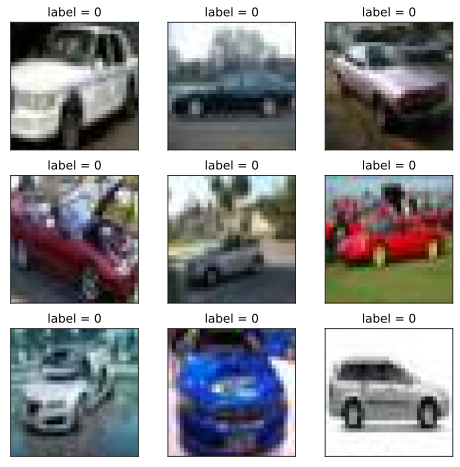

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

# 定义模型

使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。此处选择使用函数式API构建模型。



In [40]:
tf.keras.backend.clear_session() #清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)             

# 训练模型

训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。



In [41]:
import datetime
import os

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('./data/autograph/' + stamp))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)

Epoch 1/10
  1/100 [..............................] - ETA: 0s - loss: 0.6654 - accuracy: 0.7200WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - 24s 236ms/step - loss: 0.0100 - accuracy: 0.9972 - val_loss: 2.3765e-11 - val_accuracy: 1.0000
Epoch 2/10
100/100 [==============================] - 23s 230ms/step - loss: 3.0937e-11 - accuracy: 1.0000 - val_loss: 2.3718e-11 - val_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - 23s 231ms/step - loss: 2.1761e-11 - accuracy: 1.0000 - val_loss: 2.3718e-11 - val_accuracy: 1.0000
Epoch 4/10
100/100 [==============================] - 24s 239ms/step - loss: 2.7531e-11 - accuracy: 1.0000 - val_loss: 2.3718e-11 - val_accuracy: 1.0000
Epoch 5/10
100/100 [==========

# 评估模型

In [ ]:
%load_ext tensorboard
#%tensorboard --logdir ./data/keras_model

from tensorboard import notebook
notebook.list() 

#在tensorboard中查看模型
notebook.start("--logdir ./data/keras_model")

In [54]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,1.000360e-02,0.9972,2.376536e-11,1.0
2,3.093725e-11,1.0000,2.371828e-11,1.0
3,2.176126e-11,1.0000,2.371827e-11,1.0
4,2.753058e-11,1.0000,2.371826e-11,1.0
5,2.320893e-11,1.0000,2.371823e-11,1.0
6,1.957983e-11,1.0000,2.371824e-11,1.0
7,3.426895e-11,1.0000,2.371821e-11,1.0
8,2.229979e-11,1.0000,2.371817e-11,1.0
9,2.534112e-11,1.0000,2.371818e-11,1.0


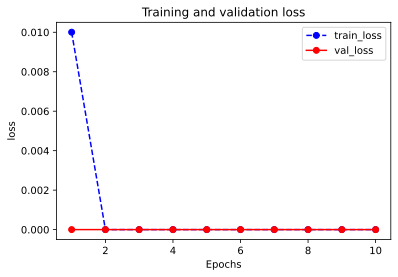

In [57]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history,"loss")


In [59]:
# 模型预测
model.predict(ds_test)

for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

[[6.7344529e-18]
 [2.4817183e-22]
 [3.6471053e-23]
 [3.2709612e-18]
 [1.2445722e-23]
 [8.8375677e-24]
 [1.5649270e-20]
 [3.0688914e-20]
 [3.0474494e-20]
 [6.7916012e-13]
 [9.7053671e-29]
 [1.6192083e-23]
 [5.9889241e-18]
 [8.3745262e-38]
 [6.2651756e-23]
 [5.1534721e-24]
 [1.4434565e-19]
 [3.4899935e-17]
 [3.5848186e-28]
 [4.6178301e-18]]


In [ ]:
# 保存模型
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署

model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(ds_test)
